# Pathology scoring VCF conversion

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.projections as pltproject
import pandas as pd
import glob
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

In [2]:
md = pd.read_pickle("../../data/precomputedData/full_human_metadata.pkl")
md = md.sort_values(by = ['donor_age'])
ages = md['donor_age'].drop_duplicates()

# Run from here if initial compilation is done

In [3]:
d_donor_mur = pd.read_pickle('../../data/precomputedData/Muraro/muraroVariantsSTAR200V1.pkl')
d_donor_eng = pd.read_pickle('../../data/precomputedData/Enge/engeVariantsSTAR200.pkl')
d_donor_voi = pd.read_pickle('../../data/precomputedData/Voigt/voigtVariantsSTAR200V1.pkl')

# Code to concat all the datasets into the same dataframe
d_donor_voi['dataset'] = 'voi'
d_donor_mur['dataset'] = 'mur'
d_donor_eng['dataset'] = 'eng'

d_donor_voi['donor_age'] = d_donor_voi.donor_id
d_donor_mur['donor_age'] = d_donor_mur.donor_id
d_donor_eng['donor_age'] = d_donor_eng.donor_id

d_donor_mur['donor_id'] = d_donor_mur['donor_id'].astype(str) + '-Mur'
d_donor_eng['donor_id'] = d_donor_eng['donor_id'].astype(str) + '-Eng'
d_donor_voi['donor_id'] = d_donor_voi['donor_id'].astype(str) + '-Voi'
d_donor_eng['SRR'] = d_donor_eng['sample_id']
d_donor_all = pd.concat([d_donor_mur,d_donor_eng,d_donor_voi], ignore_index=False, sort = False)

d_donor_all = d_donor_all.sort_values(by = ['donor_age','donor_id'])

bases=d_donor_all.groupby('donor_id').mean()['bases_passed']

eng_colour = (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)
mur_colour = (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)
voi_colour = (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

# Looking at bulk heteroplasmy and detectable mutants
Figure 1e

In [4]:
d_donor_all['bulk'] = d_donor_all['mean_HF']*d_donor_all['mutant_sequenced_prop']

nohaps=d_donor_all.drop_duplicates(subset=['donor_id','POS','ALT'])
nohaps=nohaps[nohaps.mutant_type !='Common mutation']
nohaps=nohaps[~((nohaps.mean_HF>0.95)&(nohaps.mutant_sequenced_prop>0.95))]

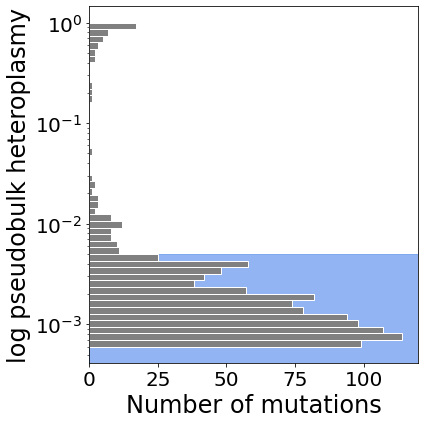

In [5]:
bin_arr= np.logspace(np.log10(0.0006),np.log10(1), 50)
plt.figure(figsize=(6,6))
plt.axhspan(5e-03,0, alpha=0.7,color='cornflowerblue',zorder=1)
h, bins, patches = plt.hist(nohaps[((nohaps.mean_HF>0.1)&(nohaps.dataset=='eng')&(nohaps.cells_possible >10))].drop_duplicates(subset=['donor_id','POS','ALT']).bulk,#density=True,
                            bins=bin_arr,orientation='horizontal',color='white', alpha=0.5,zorder=2)
i=0
for p, b in zip(patches, bins):

    p.set_color('grey')
    p.set_alpha(1)
    p.set_edgecolor('white')

plt.yscale('log')
plt.ylabel('log pseudobulk heteroplasmy',size=24)
plt.xlabel('Number of mutations',size =24)
plt.tick_params(axis='both',  labelsize=20)

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1e.pdf');

# Difference between SFSs
Figure 1f

In [6]:
bin_num=20
bin_arr = [q/bin_num for q in range(int(0.05*bin_num),bin_num+1)]
filt = d_donor_all[((d_donor_all.mutant_type == 'Cryptic')&(d_donor_all.cells_possible>10))]
filt = filt[filt['HF'] >=0.1]
age_dist={}
for age in d_donor_all.donor_id.unique():
    age_dist[age] = filt.loc[filt.donor_id == age].HF

# Make arrays of RBC-difference between every pair of distributions
stat = []
for age in filt.donor_id.unique():
    stat_temp = []
    for age1 in filt.donor_id.unique():
        stat_temp.append(1-2*stats.mannwhitneyu(age_dist[age],age_dist[age1],alternative='greater')[0]/(len(age_dist[age1])*len(age_dist[age])))
    stat.append(stat_temp)

statdf = pd.DataFrame((np.array(stat)),index = filt.donor_id.unique(), columns=filt.donor_id.unique())
x = np.triu(np.ones(statdf.shape))
np.fill_diagonal(x,0)
statdf = statdf.where(x.astype(np.bool))
statdf = statdf.stack().reset_index()
statdf.columns = ['Row','Column','Value']

age_diff = []
for age in filt.drop_duplicates(subset=['donor_id'])['donor_age']:
    po = []
    for age2 in filt.drop_duplicates(subset=['donor_id'])['donor_age']:
        po.append((age2-age))
    age_diff.append(po)

pddiff = pd.DataFrame(age_diff)
x = np.triu(np.ones(pddiff.shape))
np.fill_diagonal(x,0)
pddiff = pddiff.where(x.astype(np.bool))
pddiff = pddiff.stack().reset_index()
pddiff.columns = ['Row','Column','Value']

# Make an array labelling if the pair is within dataset or across dataset
data_diff = []
for data in filt.drop_duplicates(subset=['donor_id'])['dataset']:
    do = []
    for data1 in filt.drop_duplicates(subset=['donor_id'])['dataset']:
        if data == data1:
            do.append(data)
        else:
            do.append('mixed')
    data_diff.append(do)

datadiff = pd.DataFrame(data_diff)
x = np.triu(np.ones(datadiff.shape))
np.fill_diagonal(x,0)
datadiff = datadiff.where(x.astype(np.bool))
datadiff = datadiff.stack().reset_index()
datadiff.columns = ['Row','Column','Value']
datadiff['Dataset'] = datadiff['Value'].map({'eng':'Pancreas 1','mur':'Pancreas 2','voi':'Eye','mixed':'Mixed'})

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.bool` i

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Spearman Rank Correlation=0.705
 p=5.743e-27


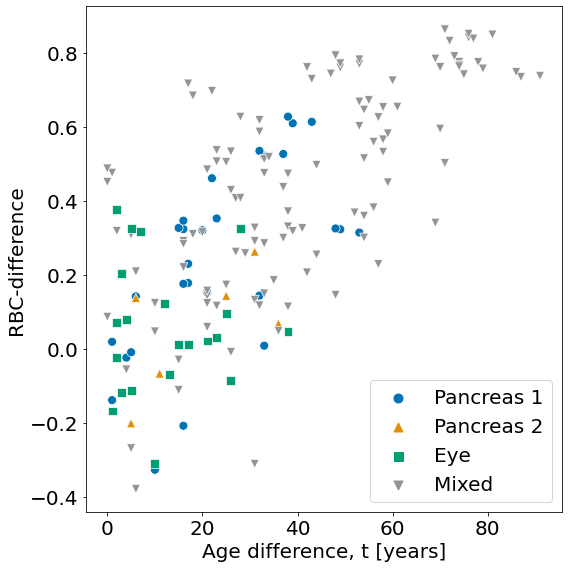

In [7]:
fig = plt.figure(figsize=(8,8))
sns.set_palette([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)])
markers = ['o','^','s','v']
sns.scatterplot(pddiff['Value'],statdf['Value'], hue=datadiff['Dataset'], hue_order=['Pancreas 1','Pancreas 2','Eye','Mixed'],
                style=datadiff['Dataset'],style_order=['Pancreas 1','Pancreas 2','Eye','Mixed'],markers=markers,s=80);

plt.xlabel('Age difference, t [years]', size = 20)
plt.ylabel('RBC-difference', size = 20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=20, markerscale=1.5)
foo = stats.spearmanr(pddiff['Value'],statdf['Value'])
print('Spearman Rank Correlation={0:.3f}\n p={1:.3e}'.format(foo[0],foo[1]))
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1f.pdf')

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


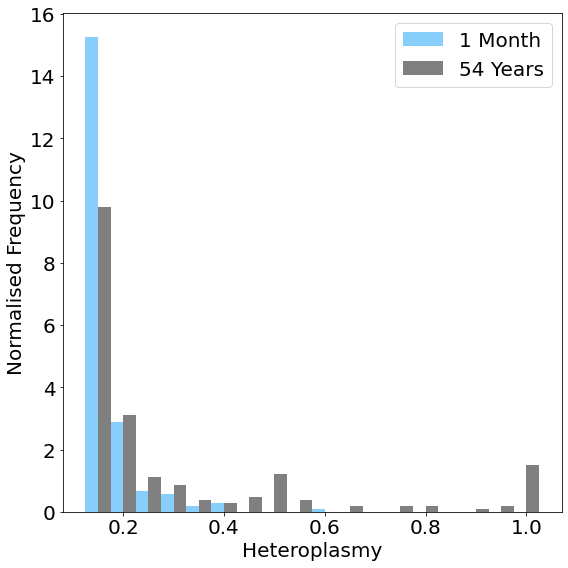

In [8]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/2,0]
colours=['#87cefaff','#808080ff']
classes=['1-Eng','54-Eng']
class_map={'1-Eng': '1 Month','54-Eng':'54 Years'}
bars = pd.DataFrame()


# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = d_donor_all[((d_donor_all.mutant_type == 'Cryptic')&(d_donor_all.cells_possible>10))]
filt = filt[filt['HF'] >=0.1]

# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.donor_id == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)


# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=0.05/2,align='edge',color=colours[i],label=class_map[age])

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Normalised Frequency', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1g.pdf')
plt.show()

# Look at the spread of homoplasmic/high heteroplasmy variants
figure 1h

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


SpearmanrResult(correlation=0.8961267605633804, pvalue=2.1118516208663329e-07)


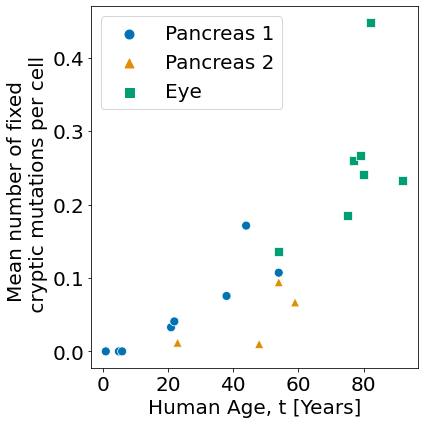

In [11]:
datamap={'Eng':'Pancreas 1','Mur':'Pancreas 2','Voi':'Eye'}

# Filter so only cryptic homoplasmic mutations are in the dataframe
homo_muts = d_donor_all[((d_donor_all.mutant_type =='Cryptic')&(d_donor_all.cells_possible>10)&(d_donor_all.HF>0.95))]

# Count all cells which contain any mutations
cells = d_donor_all.drop_duplicates(subset = 'sample_id', keep = 'first').groupby('donor_id').count()


y=[]
bars={}
dataset=[]

ages = d_donor_all.drop_duplicates(subset=['donor_id'])['donor_age']

# Loop through all donors counting the number of homoplasmies and normalised against the total cells mutations were seen in
# and the average number of bases passing quality control for that donor

for age in d_donor_all.donor_id.unique():
    
    dataset.append(datamap[age[-3:]])
    age_split = homo_muts.loc[homo_muts.donor_id == age]
    bars[age] = len(age_split)/(cells.loc[age].POS*(bases[age]/16959))
    y.append(bars[age])

plt.figure(figsize=(6,6))
colour = sns.color_palette("colorblind")
markers = ['o','^','s']
sns.scatterplot(ages,y, hue=dataset,style = dataset,style_order=['Pancreas 1','Pancreas 2','Eye'], markers=markers,s=80)
plt.legend(loc='upper left',fontsize=20, markerscale=1.5)
print(stats.spearmanr(ages,y, axis=0
                     ))
plt.xlabel('Human Age, t [Years]', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Mean number of fixed \n cryptic mutations per cell',size=20);
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure1h.pdf')

# Pathology and synonymous/non-synoymous selection
figure 2

In [12]:
import pickle
with open('../../data/precomputedData/human_syn_dict.pkl', 'rb') as handle:
    syndict = pickle.load(handle)
    
synProp = 8178/(25845+8178)
nonSynProp = 25845/(25845+8178)
d_donor_all['MUT'] = d_donor_all['REF']+d_donor_all['POS'].astype(str)+d_donor_all['ALT']
d_donor_all['SYN'] = d_donor_all.MUT.map(syndict)

In [11]:
bin_arr = [0,0.5,1.0]

nohaps=d_donor_all.drop_duplicates(subset=['donor_id','POS','ALT'])
nohaps=nohaps[nohaps['dataset']=='eng']
nohaps=nohaps[(nohaps.mutant_type!='Common mutation')&(nohaps.mutant_type!='Cryptic')]
nohaps = nohaps[nohaps.HF>0.1]

nonSynAll=(nohaps.groupby(['SYN',pd.cut(nohaps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Non-Synonymous']).DF
synAll=nohaps.groupby(['SYN',pd.cut(nohaps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Synonymous'].DF
print('All',stats.fisher_exact([[synProp*(synAll.sum()+nonSynAll.sum()),synAll.sum()],[nonSynProp*(synAll.sum()+nonSynAll.sum()),nonSynAll.sum()]]))

All (0.28982259570494867, 6.9009212862849804e-09)


In [12]:
bin_arr = [0,0.5,1.0]

cryps=d_donor_all[((d_donor_all.dataset=='eng')&(d_donor_all.mutant_type=='Cryptic')&(d_donor_all.cells_possible>10))]
cryps=cryps[((cryps.HF>0.1))]

nonSynCryp=(cryps.groupby(['SYN',pd.cut(cryps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Non-Synonymous']).DF
synCryp=cryps.groupby(['SYN',pd.cut(cryps.mean_HF, bin_arr, include_lowest=True)]).count().fillna(0).loc['Synonymous'].DF

print('Cryptics',stats.fisher_exact([[synProp*(synCryp.sum()+nonSynCryp.sum()),synCryp.sum()],[nonSynProp*(synCryp.sum()+nonSynCryp.sum()),nonSynCryp.sum()]]))

Cryptics (1.0648624533592899, 0.5611071153836256)


C:\Users\alist\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-13-f1c3b525bdcc>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


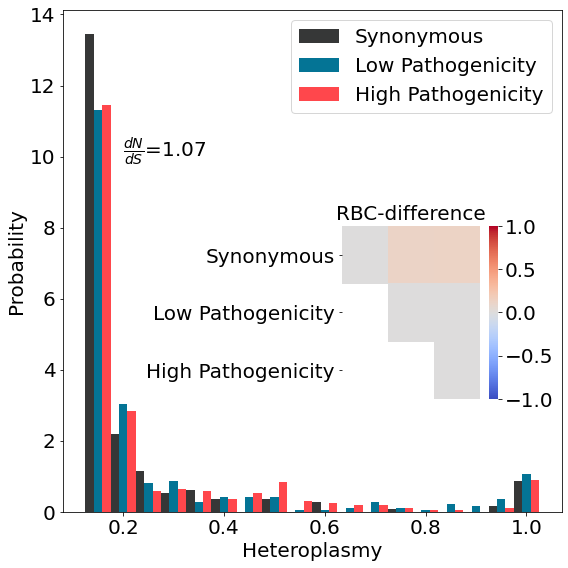

In [13]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/3,0,-0.05/3]
colours=['#363737','#047495','#ff474c']
classes=['Synonymous','Low Pathogenicity','High Pathogenicity']
bars = pd.DataFrame()

# This is just for getting only mutations which are pathology scored.
mas = {'Synonymous':'Synonymous','low_pathogenicity':'Low Pathogenicity','high_pathogenicity':'High Pathogenicity'}
patho_scored = d_donor_all[d_donor_all['MutPred_Probability'] != '.']
patho_scored['MutPred_Prediction'] = patho_scored['MutPred_Prediction'].map(mas)

# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = patho_scored[((patho_scored.cells_possible>10)&(patho_scored.dataset=='eng')&(patho_scored.mutant_type == 'Cryptic')&(patho_scored.HF > 0.1))]

# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.MutPred_Prediction == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)

# Make dataframe with rank Biserial correlation between each pair of class
stat = []
pvals = []
for pathology in classes:
    kol = []
    ager= []
    for pathology1 in classes:
        kol.append(1-2*stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[0]/(len(age_dist[pathology1])*len(age_dist[pathology])))
        ager.append(stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[1])
    pvals.append(ager)
    stat.append(kol)
biserial = pd.DataFrame(stat,index = classes, columns = classes)
   
    
# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=-0.05/3,align='center',color=colours[i],label=age)

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Probability', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Annotated with the Non-Synonymous/Synonymous ratio
plt.annotate(r'$\frac{dN}{dS}$'+'={:.2f}'.format(synProp/nonSynProp*nonSynCryp.sum()/synCryp.sum()),xy=(0.2,10),size=20)

left, bottom, width, height = [0.6, 0.3, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

# Plots just the upper triangular of the rank biserial (its just mirrored below and so unimportant)
b = sns.heatmap(biserial.where(np.triu(np.ones(biserial.shape)).astype(np.bool)[0:5,0:5]), cmap='coolwarm', center = 0,vmin=-1,vmax=1, ax=ax2)

b.set_yticklabels(classes, size = 20)
cbar = b.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('RBC-difference',size=20)
plt.xticks([])
plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure2a.pdf')
plt.show()

C:\Users\alist\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-14-2e703a662da8>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


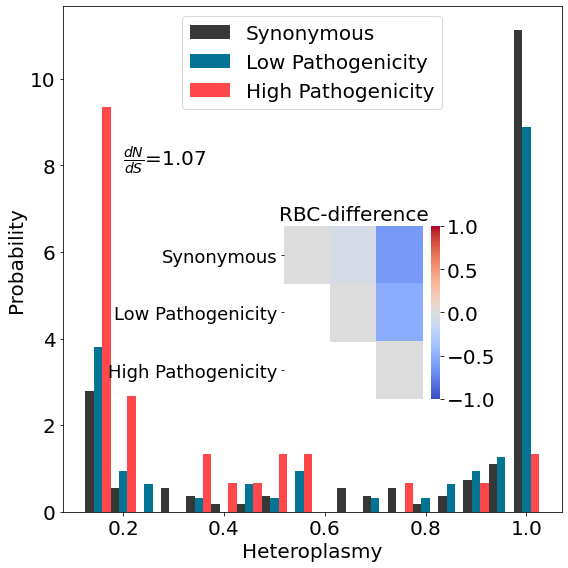

In [14]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fig, ax1 = plt.subplots( figsize=(8, 8))

# Code to get all the data to  plot
bin_arr = [q/20 for q in range(2,21)]
offsets= [0.05/3,0,-0.05/3]
colours=['#363737','#047495','#ff474c']
classes=['Synonymous','Low Pathogenicity','High Pathogenicity']
bars = pd.DataFrame()

# This is just for getting only mutations which are pathology scored.
mas = {'Synonymous':'Synonymous','low_pathogenicity':'Low Pathogenicity','high_pathogenicity':'High Pathogenicity'}
patho_scored = d_donor_all[d_donor_all['MutPred_Probability'] != '.']
patho_scored['MutPred_Prediction'] = patho_scored['MutPred_Prediction'].map(mas)

# Filters for the mutant type, dataset and heteroplasmy range we are interested in
filt = patho_scored = patho_scored[(patho_scored.cells_possible>10)&(patho_scored.dataset =='eng')&(patho_scored.mutant_type != 'Common mutation')&(patho_scored.mutant_type!='Cryptic')&(patho_scored.mean_HF>0.1)].drop_duplicates(subset=['donor_id','POS','ALT'])


# Looks at the class you are interested in, splits up mean heteroplasmy into bins and then counts the number in each bin and normalises
age_dist = {}
for pathology in classes:
    age_dist[pathology] = filt.loc[filt.MutPred_Prediction == pathology].mean_HF
    group = age_dist[pathology].groupby([pd.cut(age_dist[pathology], bin_arr, include_lowest=True)])
    bars[pathology] = group.count()
    bars[pathology] = bars[pathology]/(bars[pathology].sum()*0.05)

# Make dataframe with rank Biserial correlation between each pair of class
stat = []
for pathology in classes:
    kol = []
    for pathology1 in classes:
        kol.append(1-2*stats.mannwhitneyu(age_dist[pathology],age_dist[pathology1],alternative='two-sided')[0]/(len(age_dist[pathology1])*len(age_dist[pathology])))
    stat.append(kol)
biserial = pd.DataFrame(stat,index = classes, columns = classes)
    
    
# Start of Plotting Section:

for i,  age in enumerate(classes):
    ax1.bar(np.array(bin_arr[1:])-offsets[i],bars[age].values,width=-0.05/3,align='center',color=colours[i],label=age)

plt.legend(prop={'size': 20})
plt.xlabel('Heteroplasmy', size = 20)
plt.ylabel('Probability', size = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Annotated with the Non-Synonymous/Synonymous ratio
plt.annotate(r'$\frac{dN}{dS}$'+'={:.2f}'.format(synProp/nonSynProp*nonSynCryp.sum()/synCryp.sum()),xy=(0.2,8),size=20)

left, bottom, width, height = [0.5, 0.3, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

# Plots just the upper triangular of the rank biserial (its just mirrored below and so unimportant)
b = sns.heatmap(biserial.where(np.triu(np.ones(biserial.shape)).astype(np.bool)[0:5,0:5]), cmap='coolwarm', center = 0,vmin=-1,vmax=1, ax=ax2)

b.set_yticklabels(classes, size = 18)
cbar = b.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.title('RBC-difference',size=20)
plt.xticks([])

plt.tight_layout()
plt.savefig('../../figures/publicationFigures/figure2b.pdf')
plt.show()